# Heavy Rain - AIFS
---

In the beginning of February 2025, Northern Queensland was hit by extreme rainfall event and large areas of land were flooded. Australia's Bureau of Meteorology reported that the area had received six months of rainfall in three days. <br>

The example shows analysis of the following parameters:
- [`msl`](https://codes.ecmwf.int/grib/param-db/151) mean sea level pressure, and
- [`tp`](https://codes.ecmwf.int/grib/param-db/228228) total precipitation of the **AIFS** datasets on 31 January at 00 UTC in North Queensland (20.77° S, 144.79° E), Australia.

## 1. Set Up Your Environment and Find ECMWF Open Data
Open data will be downloaded from a publicly available [Amazon S3 Bucket](../datadownload/find-data.md). First, the following Python libraries need to be installed in the current Jupyter kernel:
- `requests` to send HTTP requests,
- `itertools` to create iterators for efficient looping,
- `json` to decode JSON data,
- `xarray` to work with labelled multi-dimensional arrays, and
- `earthkit` to analyse and plot the data.

:::{seealso}
More detailed information about how to install Python packages is available on the [Retrieve Data](../datadownload/data-download.ipynb) website.
:::
If the packages are not installed yet, uncomment the code below and run it.

In [ ]:
# !pip3 install earthkit requests itertools json xarray

In [1]:
import requests
import itertools
import json

import earthkit.data as ekd
import earthkit.plots as ekp
import earthkit

import xarray as xr
xr.set_options(keep_attrs=True)

(content:references:listParam_hra)=
### List of parameters to retrieve from open datasets
The selected values below can be modified.
- Parameters available on a single level:

In [2]:
PARAM_SFC = "tp" # "msl"
LEVELTYPE = "sfc"

DATES = [20250131]
TIME = 0
STEPS = [12]
STREAM = "oper"
TYPE = "fc"
MODEL = "aifs"
RESOL = "0p25"

:::{important}
Ensure you specify the model correctly! <br>
Before March 2025, the file-naming convention was different. In this case, we will use the `earthkit-data` package to retrieve our data instead of `ecmwf-opendata`.
For more information, visit the [Amazon S3 Buckets](../datadownload/source-aws.ipynb) website.
:::

### Get the data using the `earthkit-data` package
First we will extract information about the offset and length, byte ranges we want to read from a GRIB file.

:::{seealso}
To learn more about how to retrieve data for a specific parameter, visit [Reading file parts](https://earthkit-data.readthedocs.io/en/latest/examples/file_parts.html) website.
:::

In [3]:
def get_parts_index(date, time, step, stream, _type, model, resol, param, levelist=[]):
    """
    this function takes one parameter on a single level or a pressure level and
    returns its corresponding byte ranges extracted from the index file within a defined date range. 
    """
    
    parts = []
    timez = f"{time}".zfill(2)

    for _date in DATES:
        for _step in STEPS:
            index = f"{_date}/{timez}z/{model}/{resol}/{stream}/{_date}{timez}0000-{_step}h-{stream}-{_type}.index"        
            url = f"https://ecmwf-forecasts.s3.amazonaws.com/{index}"
            print(url)
            try:
                r = requests.get(url)
                for i, line in enumerate(r.iter_lines()):
                    line = json.loads(line)
                    if levelist == []:
                        if line.get("param") == param:
                            offset = line["_offset"]
                            length = line["_length"]
                            parts.append((offset, length))
                    else:
                        if line.get("levelist") == f"{levelist}" and line.get("param") == param:
                            offset = line["_offset"]
                            length = line["_length"]
                            parts.append((offset, length))
            except:
                print(f'Cannot find the selected index file {index}.')
    return parts

:::{seealso}
When we want to alter the values of a GRIB file, then we can store the result in a new array fieldlist straight from metadata and these modified values. More detailed information about building an array fieldlist in a loop, can be found [here](https://earthkit-data.readthedocs.io/en/latest/examples/grib_array_backends.html).
:::

In [4]:
def get_open_data_earthkit(date, time, step, stream, _type, model, resol, parts, scale):
    files = ekd.SimpleFieldList()
    timez = f"{time}".zfill(2)

    # Get the data for all dates and steps
    for _date in DATES:
        for _step in STEPS:
            filename = f"{_date}/{timez}z/{model}/{resol}/{stream}/{_date}{timez}0000-{_step}h-{stream}-{_type}.grib2"
            data = ekd.from_source("s3", {
                "endpoint": "s3.amazonaws.com",
                "region": "eu-central-1",
                "bucket": "ecmwf-forecasts",
                "objects": { "object": filename, "parts": parts.pop(0)},
                }, anon=True)
            md = data.metadata()
            v = data.to_array() / scale
            for f in range(len(md)):
                files.append(ekd.ArrayField(v[f], md[f]))
    return files

## 2. Total precipitation

A unit of total precipitation is kg/m$^2$. 1 kg of rainwater fills an area of 1 m$^2$ with the water of height 1 mm. <br>
In the [ECMWF Open Charts](https://charts.ecmwf.int/), total precipitation is also plotted in millimetres.

In [5]:
parts_pair = get_parts_index(date=DATES,
                        time=TIME,
                        step=STEPS,
                        stream=STREAM,
                        _type=TYPE,
                        model=MODEL,
                        resol=RESOL,
                        param=PARAM_SFC,
                        levelist=[])
parts_pair

https://ecmwf-forecasts.s3.amazonaws.com/20250131/00z/aifs/0p25/oper/20250131000000-12h-oper-fc.index


[(1132461, 702819)]

In [6]:
tp = get_open_data_earthkit(date=DATES,
                               time=TIME,
                               step=STEPS,
                               stream=STREAM,
                               _type=TYPE,
                               model=MODEL,
                              resol=RESOL,
                              parts=parts_pair,
                              scale = 1)
tp.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,tp,surface,0,20250131,0,0-12,fc,None,regular_ll


## 2.1 Total precipitation within a defined lead time range
The input values can be set [here](#content:references:listParam_hra).

In [7]:
PARAM_SFC = "tp"
LEVELS = []
LEVELTYPE = "sfc"

DATES = [20250130]
TIME = 0
STEPS = [12, 24, 36, 48, 60, 72, 84, 96]
STREAM = "oper"
TYPE = "fc"
MODEL = "aifs"
RESOL = "0p25"

In [8]:
parts_pair = get_parts_index(date=DATES,
                        time=TIME,
                        step=STEPS,
                        stream=STREAM,
                        _type=TYPE,
                        model=MODEL,
                        resol=RESOL,
                        param=PARAM_SFC,
                        levelist=[])
parts_pair

https://ecmwf-forecasts.s3.amazonaws.com/20250130/00z/aifs/0p25/oper/20250130000000-12h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250130/00z/aifs/0p25/oper/20250130000000-24h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250130/00z/aifs/0p25/oper/20250130000000-36h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250130/00z/aifs/0p25/oper/20250130000000-48h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250130/00z/aifs/0p25/oper/20250130000000-60h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250130/00z/aifs/0p25/oper/20250130000000-72h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250130/00z/aifs/0p25/oper/20250130000000-84h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250130/00z/aifs/0p25/oper/20250130000000-96h-oper-fc.index


[(49321486, 821654),
 (16844884, 793168),
 (32208164, 852003),
 (51523998, 773624),
 (43427834, 808679),
 (48520101, 836064),
 (45651027, 860569),
 (45674744, 757874)]

The `tp` parameter gives information about total accumulated rainfall from the start of the forecast onwards. For instance, `step=12` indicates accumulated precipitation from 00 UTC until 12 UTC, `step=96` from 00 UTC up to 4 days ahead.

In [9]:
tp_steps = get_open_data_earthkit(date=DATES,
                               time=TIME,
                               step=STEPS,
                               stream=STREAM,
                               _type=TYPE,
                               model=MODEL,
                              resol=RESOL,
                              parts=parts_pair,
                              scale = 1)
tp_steps.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,tp,surface,0,20250130,0,0-12,fc,None,regular_ll
1,ecmf,tp,surface,0,20250130,0,0-24,fc,None,regular_ll
2,ecmf,tp,surface,0,20250130,0,0-36,fc,None,regular_ll
3,ecmf,tp,surface,0,20250130,0,0-48,fc,None,regular_ll
4,ecmf,tp,surface,0,20250130,0,0-60,fc,None,regular_ll
5,ecmf,tp,surface,0,20250130,0,0-72,fc,None,regular_ll
6,ecmf,tp,surface,0,20250130,0,0-84,fc,None,regular_ll
7,ecmf,tp,surface,0,20250130,0,0-96,fc,None,regular_ll


## 3. Mean sea level pressure
The input values can be set [here](#content:references:listParam_hra).

In [8]:
parts_pair = get_parts_index(date=DATES,
                        time=TIME,
                        step=STEPS,
                        stream=STREAM,
                        _type=TYPE,
                        model=MODEL,
                        resol=RESOL,
                        param=PARAM_SFC,
                        levelist=[])
parts_pair

https://ecmwf-forecasts.s3.amazonaws.com/20250131/00z/aifs/0p25/oper/20250131000000-12h-oper-fc.index


[(58928262, 488859)]

We will plot mean sea level pressure data in hPa, therefore we need to divide them by 100.

In [10]:
msl = get_open_data_earthkit(date=DATES,
                            time=TIME,
                            step=STEPS,
                            stream=STREAM,
                            _type=TYPE,
                            model=MODEL,
                            resol=RESOL,
                            parts=parts_pair,
                            scale = 100)
msl.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,msl,meanSea,0,20250131,0,12,fc,None,regular_ll


## 4. Data visualisation

The plot below shows the analysis of mean sea level pressure and total precipitation on 31 January 2025.

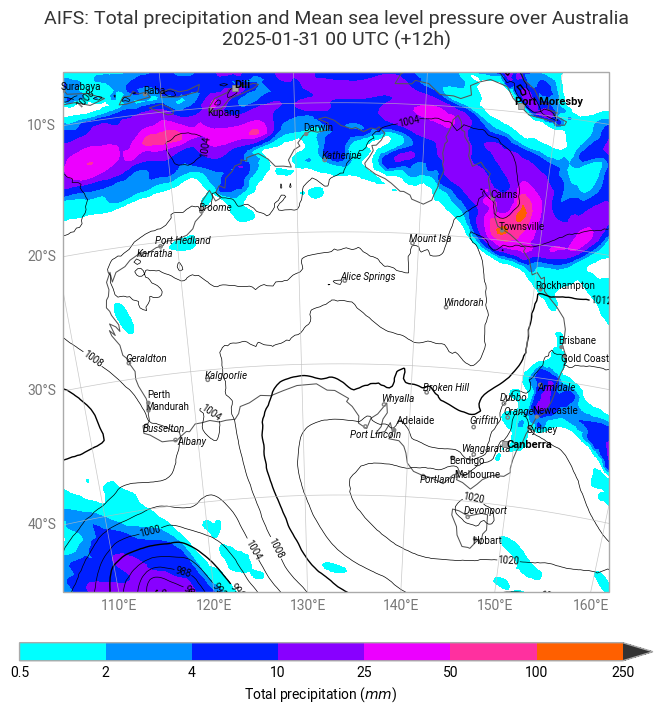

In [19]:
chart = ekp.Map(domain="Australia")

hex_colours = ['#00ffff', '#0080ff', '#0000ff', '#d900ff', '#ff00ff', '#ff8000', '#ff0000', '#333333', ]

tp_shade = ekp.styles.Style(
    colors = hex_colours,
    levels = [0.5, 2, 4, 10, 25, 50, 100, 250],
    units = "mm",
    extend = "max",
)

chart.contourf(tp, style=tp_shade)
chart.contour(msl,
              levels={"step": 4, "reference": 1000},
              linecolors="black",
              linewidths=[0.5, 1, 0.5, 0.5],
              labels = True,
              legend_style = None,
              transform_first=True)

chart.coastlines(resolution="low")
chart.gridlines()
chart.cities(adjust_labels=True)

chart.legend(location="bottom", label="{variable_name} ({units})")

chart.title(
    "AIFS: {variable_name} over {domain}\n"
    "{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)\n",
    fontsize=14, horizontalalignment="center",
)
chart.save(f"./plots/{''.join(PARAM_SFC)}_{MODEL}_{DATES[-1]}{TIME}-{STEPS[-1]}h.png")
chart.show()

The plots below show analyses of total precipitation from 30 January at 00 UTC to 3 February, every 12 hours.

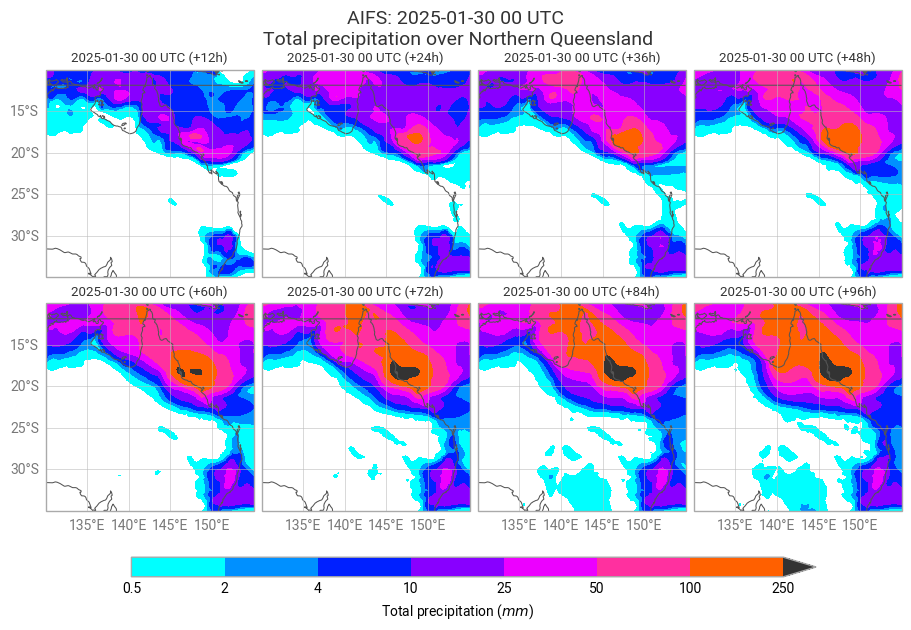

In [24]:
figure = ekp.Figure(domain=[130, 155, -35, -10], size=(9, 8), rows=3, columns=4)

hex_colours = ['#00ffff', '#0080ff', '#0000ff', '#d900ff', '#ff00ff', '#ff8000', '#ff0000', '#333333', ]

tp_shade = ekp.styles.Style(
    colors = hex_colours,
    levels = [0.5, 2, 4, 10, 25, 50, 100, 250],
    units = "mm",
    extend = "max",
)

for i in range(8):
    figure.add_map(1+i//4, i%4)

figure.contourf(tp_steps, style=tp_shade)

figure.coastlines()
figure.gridlines()

figure.legend(label="{variable_name} ({units})")

figure.subplot_titles("{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)")
figure.title(
    "AIFS: {base_time:%Y-%m-%d %H} UTC\n {variable_name} over Northern Queensland\n\n",
    fontsize=14, horizontalalignment="center",
)
figure.save(fname=f"./plots/{PARAM_SFC}_{MODEL}_{DATES[-1]}{TIME}-{'-'.join(map(str, STEPS))}h.png")
figure.show()

Since 31 January 2025, total accumulated rainfall has broken multiple records across north Queensland. Record-crushing level of rain was observed in the coastal area north from Townsville.